In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
!curl -O  https://lazyprogrammer.me/course_files/airline_passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2036  100  2036    0     0   2213      0 --:--:-- --:--:-- --:--:--  2220


In [57]:
df=pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [58]:
alpha=0.2

In [59]:
df['EWMA']=df['Passengers'].ewm(alpha=alpha,adjust=False).mean()

<Axes: xlabel='Month'>

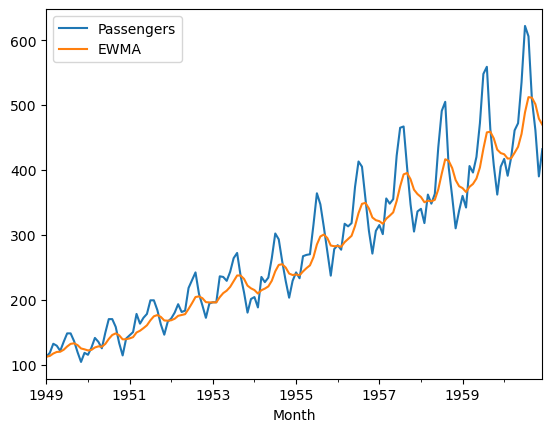

In [60]:
df.plot()

In [61]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [62]:
ses=SimpleExpSmoothing(df['Passengers'])

C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [63]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [64]:
df.index.freq='MS'

In [65]:
ses=SimpleExpSmoothing(
df['Passengers'],
initialization_method='legacy-heuristic')

In [66]:
res = ses.fit(smoothing_level=alpha,optimized=False)

In [67]:
res

In [68]:
res.predict(start=df.index[0],end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [69]:
df['SES']=res.predict(start=df.index[0],end=df.index[-1])

In [70]:
np.allclose(df['SES'],res.fittedvalues) # It means the predict function return the same values as the fitted values

True

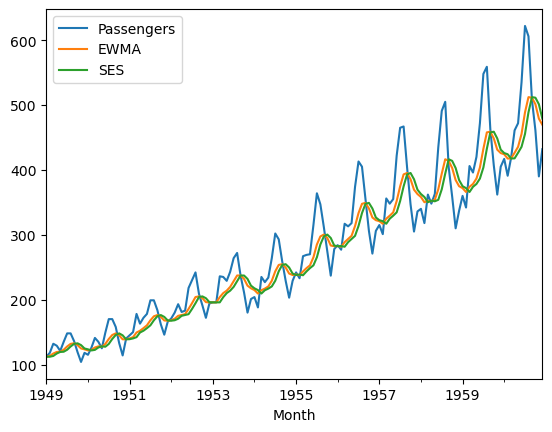

In [71]:
df.plot();

In [72]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [73]:
df['SES-1']=df['SES'].shift(-1)

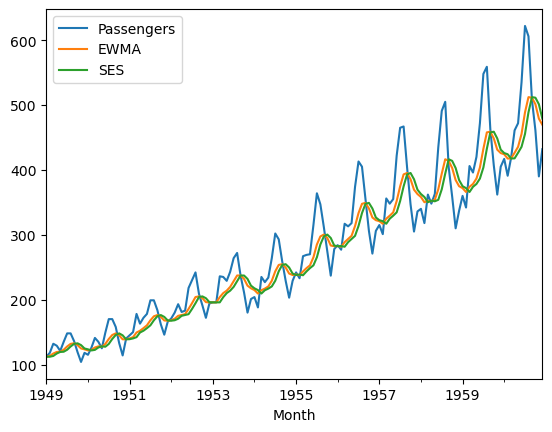

In [74]:
### NO !!!
df[['Passengers','EWMA','SES']].plot();

In [75]:
N_test=12
train=df.iloc[:-N_test]
test=df.iloc[-N_test:]

In [76]:
ses=SimpleExpSmoothing(
train['Passengers'],
initialization_method='legacy-heuristic')
res=ses.fit() # I will not define alpha, it finds the best alpha to that it minimizes the squared error

In [77]:
# Boolean series to index df rows
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

<Axes: xlabel='Month'>

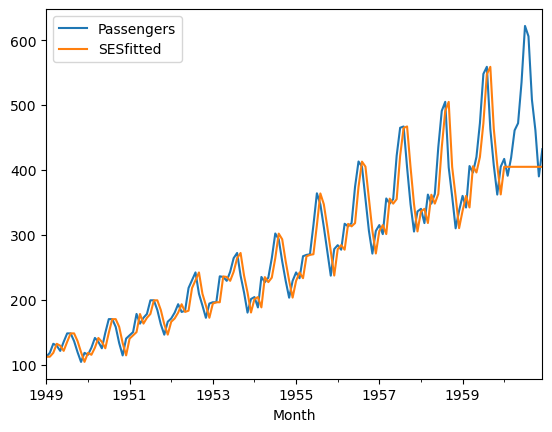

In [78]:
df.loc[train_idx,'SESfitted']=res.fittedvalues
df.loc[test_idx,'SESfitted']=res.forecast(N_test)
df[['Passengers','SESfitted']].plot()

In [79]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [80]:
# Holt's Linear Trend Model
from statsmodels.tsa.holtwinters import Holt

In [81]:
holt = Holt(
df['Passengers'],
initialization_method='legacy-heuristic')

In [82]:
res_h=holt.fit()

In [83]:
df['Holt']=res_h.fittedvalues

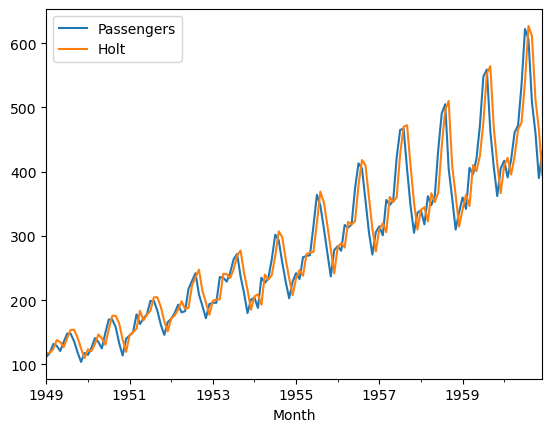

In [84]:
df[['Passengers','Holt']].plot();

In [85]:
holt=Holt(train['Passengers'],initialization_method='legacy-heuristic')
res_h=holt.fit()
df.loc[train_idx,'Holt']=res_h.fittedvalues

In [86]:
df.loc[test_idx,'Holt']=res_h.forecast(N_test)

<Axes: xlabel='Month'>

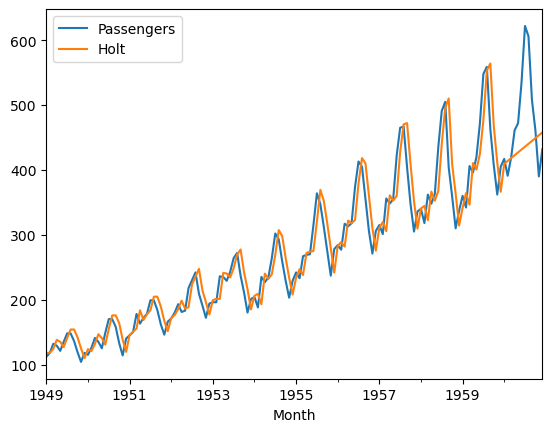

In [87]:
df[['Passengers','Holt']].plot()

## Holts Winter's Method

<Axes: xlabel='Month'>

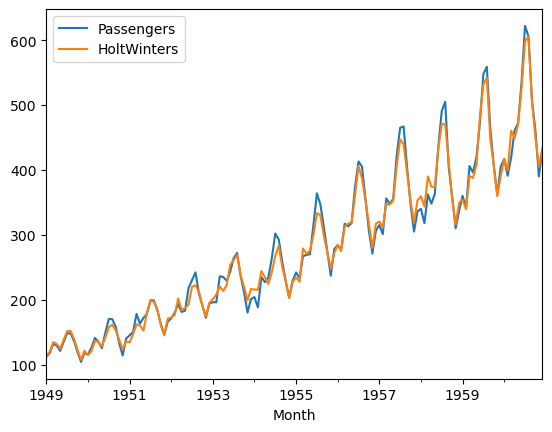

In [99]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Train the model on the training data
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12
)

res_hw = hw.fit()

# Store the fitted values (predictions) for the training data
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

# Forecast for the test data and store in the same column
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(len(test_idx))

# Plot the actual data and the Holt-Winters predictions
df[['Passengers', 'HoltWinters']].plot()


In [100]:
def rmse(y,t):
    return np.sqrt(np.mean((y-t)**2))
    

In [104]:
def mae(y, t):
    return np.mean(np.abs(y - t))

In [105]:
print("Train RMSE:",rmse(train['Passengers'],res_hw.fittedvalues))
print("Test RMSE:",rmse(test['Passengers'],res_hw.forecast(N_test)))

Train RMSE: 11.85299095520193
Test RMSE: 15.543100670388347


In [106]:
print("Train MAE:",mae(train['Passengers'],res_hw.fittedvalues))
print("Test MAE:",mae(test['Passengers'],res_hw.forecast(N_test)))

Train MAE: 8.892104927928703
Test MAE: 10.438196566901533


<Axes: xlabel='Month'>

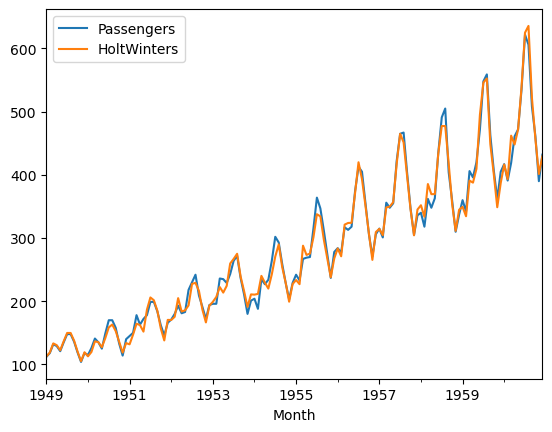

In [107]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Train the model on the training data
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12
)

res_hw = hw.fit()

# Store the fitted values (predictions) for the training data
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

# Forecast for the test data and store in the same column
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(len(test_idx))

# Plot the actual data and the Holt-Winters predictions
df[['Passengers', 'HoltWinters']].plot()


In [108]:
print("Train RMSE:",rmse(train['Passengers'],res_hw.fittedvalues))
print("Test RMSE:",rmse(test['Passengers'],res_hw.forecast(N_test)))

Train RMSE: 10.153934838980353
Test RMSE: 16.535213629970546


In [109]:
print("Train MAE:",mae(train['Passengers'],res_hw.fittedvalues))
print("Test MAE:",mae(test['Passengers'],res_hw.forecast(N_test)))

Train MAE: 7.552052558789125
Test MAE: 10.683341968320917


<Axes: xlabel='Month'>

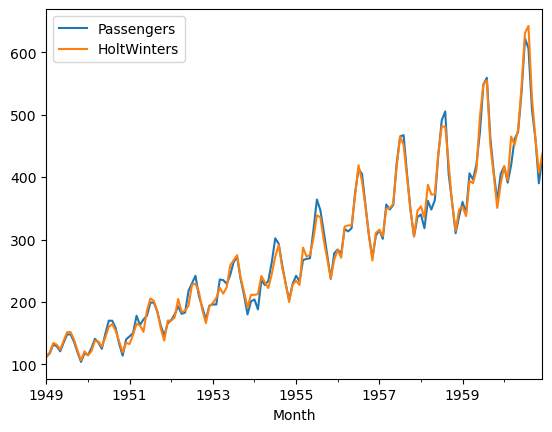

In [110]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Train the model on the training data
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12
)

res_hw = hw.fit()

# Store the fitted values (predictions) for the training data
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

# Forecast for the test data and store in the same column
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(len(test_idx))

# Plot the actual data and the Holt-Winters predictions
df[['Passengers', 'HoltWinters']].plot()


In [111]:
print("Train RMSE:",rmse(train['Passengers'],res_hw.fittedvalues))
print("Test RMSE:",rmse(test['Passengers'],res_hw.forecast(N_test)))

Train RMSE: 9.887178133833366
Test RMSE: 19.102077503386703


In [112]:
print("Train MAE:",mae(train['Passengers'],res_hw.fittedvalues))
print("Test MAE:",mae(test['Passengers'],res_hw.forecast(N_test)))

Train MAE: 7.408707261332626
Test MAE: 13.450494045059623


The model is overfitting